In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

## Setup

In [3]:
PATH = Path('data/pascal')
trn_j = json.load((PATH / 'PASCAL_VOC/pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [4]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [6]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

## Bbox per cell

### Set up data

In [52]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
# f_model = resnet50
sz=224
bs=64

In [8]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [9]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [10]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

In [11]:
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [12]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [13]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [14]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [15]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [16]:
# x,y=to_np(next(iter(md.val_dl)))
# x=md.val_ds.ds.denorm(x)

In [ ]:
# fig, axes = plt.subplots(3, 4, figsize=(16, 12))
# for i,ax in enumerate(axes.flat):
#     show_ground_truth(ax, x[i], y[0][i], y[1][i])
# plt.tight_layout()

### Create anchors

In [16]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

somehow we need 15489 anchors...

if we use ```anc_grids = [32,24,9,6,2]``` we can get 15489 anchors, but they are really crappy anchors (too small and don't cover any large areas).  Something is not right.

In [17]:
# anc_grids = [32, 64]
# anc_grids = [32,24,9,6,2]
anc_grids = [4, 3, 2, 1]
# anc_grids = [4]
anc_zooms = [0.75, 1., 1.25]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]

In [18]:
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [19]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [20]:
anchors.size()

torch.Size([270, 4])

In [83]:
#9
15489/5

3097.8

In [64]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [65]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

In [73]:
a.shape

(61956,)

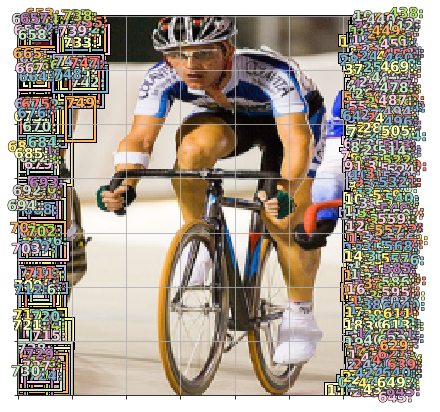

In [78]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a[55000:58000])

### Loss and plot functions

In [21]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

# loss_f = BCE_Loss(len(id2cat))

Focal loss

In [22]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
#         pt = p if t else (1-p)
        pt = p*t + (1-p)*(1-t)
#         w = alpha if t else (1-alpha)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [23]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [24]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False, use_ab=True):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, (anchor_cnr if use_ab else a_ic).data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

def ssd_loss2(pred,targ):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,use_ab=False)
        lls += loc_loss
        lcs += clas_loss
    return lls+lcs

In [25]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [26]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

### Model

In [27]:
class StdConv(nn.Module):
    def __init__(self, nin, nout=256, kernal=3, stride=2, drop=0.1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, kernal, stride=stride, padding=padding)
#         self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
#     def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
    def forward(self, x): return self.drop(self.conv(x))

In [28]:
class Subnet(nn.Module):
    def __init__(self, k, a, bb=True):
        '''
        k: number of classes
        a: number of anchors
        bb: True if bbox subnet, false if classification subnet
        '''
        super().__init__()
        self.k = k
        self.bb = bb
        self.l1, self.l2, self.l3, self.l4 = [StdConv(256, stride=1, padding=1) for _ in range(4)]
        if bb:
            self.l5_out = StdConv(256, nout=4*a, stride=1, padding=1)
        else:
            self.l5_out = StdConv(256, nout=k*a, stride=1, padding=1)
    def reshape_output(self,x):
        '''
        reshapes output
        TODO may not need permute step, check input shape
        '''
        if self.bb:
            return x.permute(0,2,3,1).contiguous().view(x.size(0),-1,4)
        else:
            return x.permute(0,2,3,1).contiguous().view(x.size(0),-1,self.k)
            
    def forward(self,x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.l4(x)
        x = F.relu(x)
        x = self.l5_out(x)
        return self.reshape_output(x)


In [50]:
class RetinaNet(nn.Module):
    def __init__(self,  backbone, k, a=9, c5_f_size=512):
        '''
        backbone: function that should return a torchvision model (right now only works w/ retinanet34)
        k: number of classes
        a: number of anchors
        '''
        super().__init__()
        #ResNet base
        self.c1 = nn.Sequential( *list( backbone().children() )[:4] )
        self.c2 = nn.Sequential( *list( backbone().children() )[4] ) #64 output size
        self.c3 = nn.Sequential( *list( backbone().children() )[5] ) #128 output size
        self.c4 = nn.Sequential( *list( backbone().children() )[6] ) #256 output size
        self.c5 = nn.Sequential( *list( backbone().children() )[7] ) #512 output size
        
        #FPN
        self.p5_in = StdConv(c5_f_size, kernal=1, stride=1)
        self.p5_up = nn.Upsample(scale_factor=2, mode='nearest')
        self.p5_out = StdConv(256, kernal=3, stride=1)
        #note this is not the traditional padding, but would have to use bilinear upsample otherwise
        self.p4_in = StdConv( int(c5_f_size/2), kernal=1, stride=1, padding=2)
        self.p4_up = nn.Upsample(scale_factor=2, mode='nearest')
        self.p4_out = StdConv(256, kernal=3, stride=1)
        #note this is not the traditional padding, but would have to use bilinear upsample otherwise
        self.p3_in = StdConv( int(c5_f_size/4), kernal=1, stride=1, padding=4)
        self.p3_out = StdConv(256, kernal=3, stride=1)
        
        self.p6 = StdConv(c5_f_size)
        self.p7 = StdConv(256)
        
        #Subnets
        self.subnet_bb = Subnet(k, a, bb=True)
        self.subnet_cls = Subnet(k, a, bb=False)
        
    def forward(self,x):
        #ResNet base
        x = self.c1(x)
        x = self.c2(x)
        c3 = self.c3(x)
        c4 = self.c4(c3)
        c5 = self.c5(c4)
        
        #FPN
        p5 = self.p5_in(c5)
        p5_upsampled = self.p5_up(p5)
        
        p4 = self.p4_in(c4)
        p4 = torch.add(p4,p5_upsampled)
        p4_upsampled = self.p4_up(p4)
        
        p3 = self.p3_in(c3)
        p3 = torch.add(p3,p4_upsampled)
        
        p5_out = self.p5_out(p5)
        p4_out = self.p4_out(p4)
        p3_out = self.p3_out(p3)
        
        p6_out = self.p6(c5)
        p7 = F.relu(p6_out)
        p7_out = self.p7(p7)
        
        #subnets
        bb = []
        cls = []
        for p_out in [p7_out, p6_out, p5_out, p4_out, p3_out]:
#             print(p_out.size())
            bb.append( self.subnet_bb(p_out) )
            cls.append( self.subnet_cls(p_out) )
        
        return [torch.cat(cls,1), torch.cat(bb,1)]

In [30]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)

In [31]:
x.shape

torch.Size([64, 3, 224, 224])

In [53]:
models = BasicModel(RetinaNet(f_model, len(cat2id)+1).cuda(),
                    name='RetinaNet')

In [54]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [55]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100,lr/10,lr])

In [56]:
out = learn.model(x)

In [57]:
[o.shape for o in out]

[torch.Size([64, 15489, 21]), torch.Size([64, 15489, 4])]

somehow we have to get to 15489 anchors...

In [41]:
ssd_loss(out, y, True)


 0.3823
 0.2860
 0.3091
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.2117
 0.3934
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.2841
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3066
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2874
 0.4685
 0.2867
 0.3659
 0.2990
 0.6481
 0.4323
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3293
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.5110
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3990
 0.4426
 0.4236
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.4334
 0.5208
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.4176
 0.4030
 0.3416
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.2928
 0.2879
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.2290
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.7722
 0.5395
 0.6392
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.3370
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3910
 0.2634
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3682
 0.3672
[torch.cuda.FloatTensor of size 2 (GPU 0)]



Variable containing:
1.00000e+05 *
  1.2848
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [42]:
learn.lr_find(.001,10)

A Jupyter Widget

 62%|██████▎   | 20/32 [00:19<00:11,  1.00it/s, loss=1.45e+07]

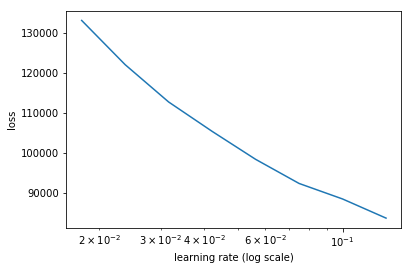

In [43]:
learn.sched.plot(n_skip_end=2)

In [47]:
lrs = .01

In [45]:
learn.fit(.01, 1, cycle_len=10, use_clr=(20,10))

A Jupyter Widget

 22%|██▏       | 7/32 [00:06<00:24,  1.01it/s, loss=3.77e+04] 


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/jeff/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jeff/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jeff/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      149129.990757 94.222717 
    1      59497.452839 34.282333                             
    2      33372.980162 25.183479                             
    3      22630.362581 24.731785                             
    4      17612.302605 22.492674                             
    5      15130.263638 21.273209                             
    6      13866.959298 21.275101                             
    7      13214.785393 21.557072                             
    8      12876.433521 21.497345                             
    9      12700.209595 21.754906                             



[21.754906]

In [46]:
learn.save('ret_10')

In [48]:
learn.lr_find(lrs/1000,1.)

A Jupyter Widget

 75%|███████▌  | 24/32 [00:20<00:06,  1.18it/s, loss=1.85e+06]

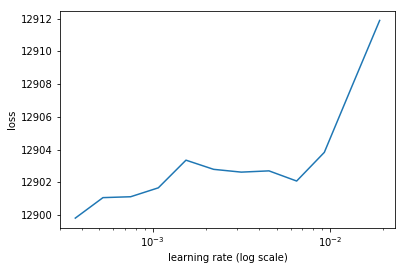

In [49]:
learn.sched.plot(n_skip_end=2)

In [54]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(20,10))

A Jupyter Widget

 12%|█▎        | 4/32 [00:04<00:31,  1.12s/it, loss=1.29e+04] 


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/jeff/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jeff/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jeff/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      12506.540032 22.695745 
    1      12503.552649 20.957745                             
    2      12505.587649 20.290283                             
    3      12505.248715 20.667593                             
    4      12505.722509 20.426361                             
    5      12503.675845 20.426754                             
    6      12504.831485 21.356396                             
    7      12504.889314 21.014069                             
    8      12501.98825 20.379578                              
    9      12502.322677 20.53064                              



[20.53064]

In [55]:
learn.save('ret_20')

In [472]:
learn.load('ret_20')

In [46]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      11.271755  13.27566  
    1      11.635916  13.003213                           
    2      11.414484  12.430294                           
    3      11.014077  12.407986                           
    4      10.52093   11.979612                           
    5      10.114142  11.83981                            
    6      9.638641   11.590225                           
    7      9.228665   11.500385                           
    8      8.871302   11.474643                           
    9      8.599259   11.318106                           



[11.318106]

In [47]:
learn.save('drop4')

In [39]:
learn.load('drop4')

In [48]:
learn.unfreeze()
learn.fit(lrs/8, 1, cycle_len=10, use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      8.245242   11.768431 
    1      8.519815   11.905796                           
    2      8.510465   11.653893                           
    3      8.397916   11.514997                           
    4      8.197456   11.54417                            
    5      8.041767   11.535892                           
    6      7.84805    11.56054                            
    7      7.674395   11.466718                           
    8      7.543331   11.35899                            
    9      7.393453   11.363176                           



[11.363176]

In [49]:
learn.save('drop4_uf')

In [506]:
learn.load('drop4_uf')

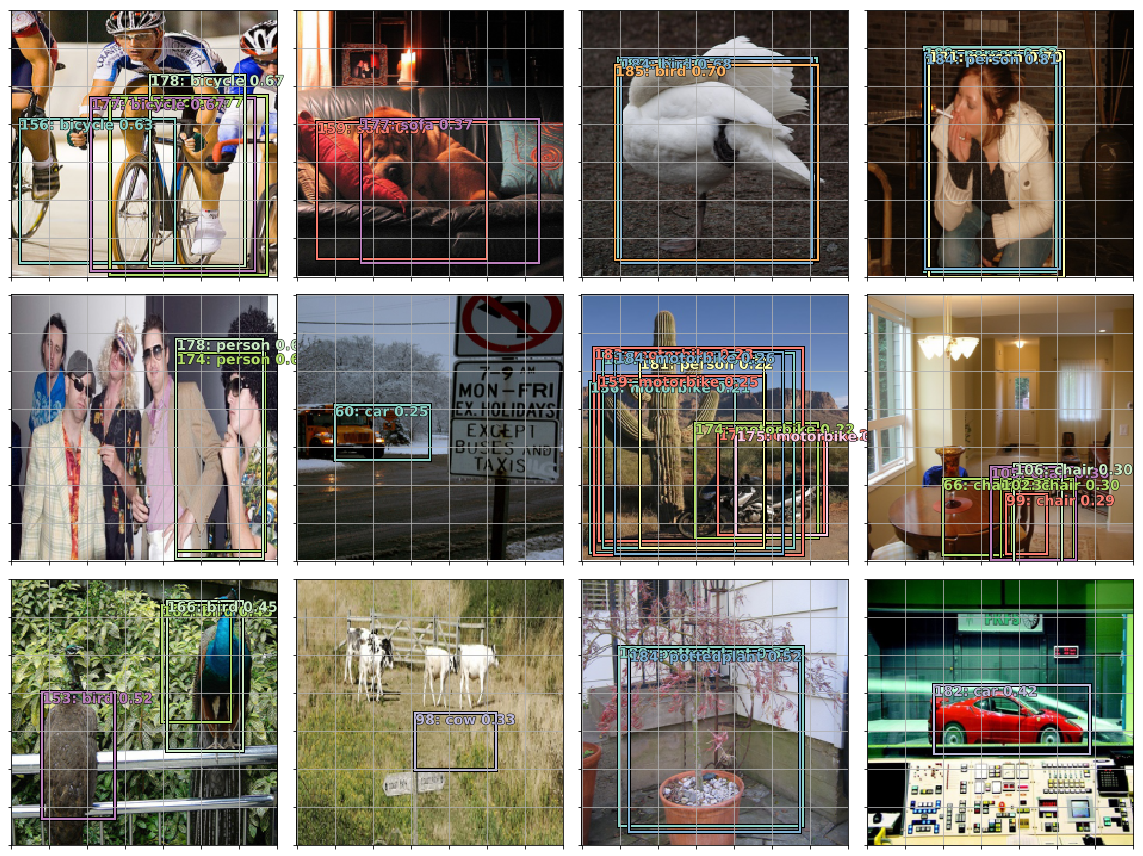

In [53]:
plot_results(0.8)

In [54]:
learn.fit(lrs/2, 1, cycle_len=10, use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      8.575215   14.983721 
    1      10.810198  15.032656                           
    2      11.256859  13.298353                           
    3      10.79743   12.559969                           
    4      10.246303  12.058713                           
    5      9.693961   11.927066                           
    6      9.131353   11.87945                            
    7      8.619632   11.679266                           
    8      8.232421   11.39998                            
    9      7.866284   11.351808                           



[11.351808]

In [55]:
learn.save('fl0')

In [56]:
learn.freeze_to(-2)
learn.fit(lrs/4, 1, cycle_len=10, use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      7.488966   11.964247 
    1      7.875672   12.311313                           
    2      8.053065   12.151535                           
    3      7.987075   12.021027                           
    4      7.793611   11.871523                           
    5      7.505379   11.632468                           
    6      7.259242   11.495307                           
    7      7.087295   11.503437                           
    8      6.873947   11.492877                           
    9      6.702066   11.486578                           



[11.486578]

In [57]:
learn.save('drop4')

In [58]:
learn.unfreeze()
learn.fit(lrs/8, 1, cycle_len=10, use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      6.516522   11.713236 
    1      6.608812   11.77958                            
    2      6.622294   11.708697                           
    3      6.602915   11.817616                           
    4      6.50995    11.687695                           
    5      6.397084   11.858427                           
    6      6.29815    11.663465                           
    7      6.203031   11.760731                           
    8      6.075785   11.650639                           
    9      6.008543   11.658834                           



[11.658834]

In [59]:
learn.save('drop4_uf')

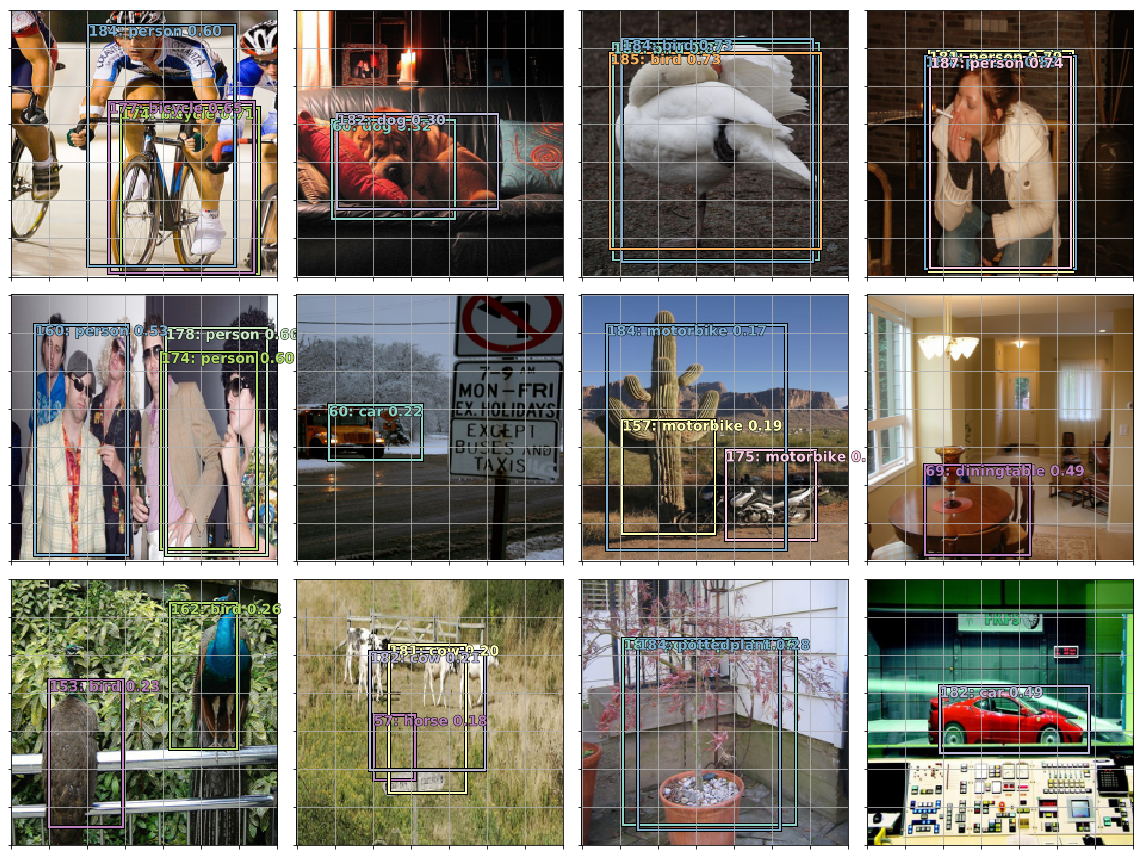

In [60]:
plot_results(0.8)

### NMS

In [57]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [58]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [59]:
idx=0
ima=md.val_ds.ds.denorm(x)[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
a_ic = actn_to_bb(b_bb[idx], anchors)
clas_pr, clas_ids = b_clas[idx].max(1)
clas_pr = clas_pr.sigmoid()

conf_scores = b_clas[idx].sigmoid().t().data

In [62]:
out1,out2,cc = [],[],[]
for cl in range(0, len(conf_scores)-1):
    c_mask = conf_scores[cl] > 0.2
    if c_mask.sum() == 0: continue
    scores = conf_scores[cl][c_mask]
    l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
    boxes = a_ic[l_mask].view(-1, 4)
    ids, count = nms(boxes.data, scores, 0.4, 50)
    ids = ids[:count]
    out1.append(scores[ids])
    out2.append(boxes.data[ids])
    cc.append([cl]*count)
cc = T(np.concatenate(cc))
out1 = torch.cat(out1)
out2 = torch.cat(out2)

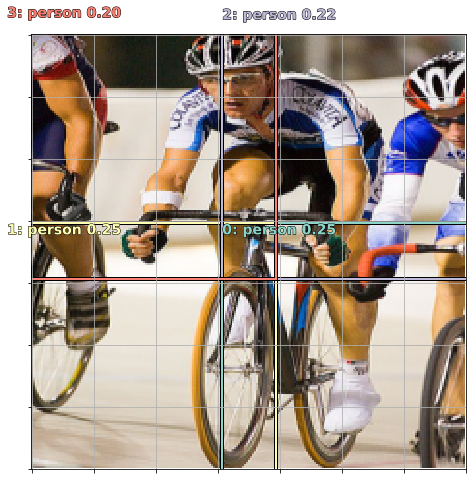

In [63]:
fig, ax = plt.subplots(figsize=(8,8))
torch_gt(ax, ima, out2, cc, out1, 0.1)

## End